# Neural Machine Translation with Attention

Advanced Learning Fall 2024.   
Last updated: 2025-01-12


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 205437643
~~~

~~~
STUDENT GIT LINK: https://github.com/DavidOriel/Adv.-computational-learning-and-data-analysis---52025
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2024_ID_[205437643].html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
# import unicodedata
import re
import random
import unicodedata

import time
import math
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import numpy as np
from keras.models import Sequential,Model
from keras.layers import LSTM, Dense, Input, RepeatVector, TimeDistributed, Attention, Concatenate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

1.2).

a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   

1.3).  

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [2]:
config = {}
config["training_size"] = 40000
config["digits"] = 4
config["hidden_size"] = 128
config["batch_size"] = 128
config["iterations"] = 50
chars = '0123456789-+ '

SOLUTION:  
Defining the classes for generating the training set.

In [3]:
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)



Creating the Training set

In [ ]:
maxlen = config["digits"] + 1 + config["digits"]
questions = []
expected = []
seen = set()
ctable = CharacterTable(chars)
print('Generating data...')
while len(questions) < config["training_size"]:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, config["digits"] + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    sign = np.random.choice(['-', '+'])


    if sign == '+':
        q = '{}+{}'.format(a, b)
        ans_value = a + b
    else:  # sign == '-'
        q = '{}-{}'.format(a, b)
        ans_value = a - b

    # Pad the query so it is always 'maxlen' in length
    query = q + ' ' * (maxlen - len(q))

    # Convert answer to string, pad to length 'digits + 1'
    ans = str(ans_value)
    ans += ' ' * (config["digits"] + 1 - len(ans))

    questions.append(query)
    expected.append(ans)

print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.float32)
y = np.zeros((len(questions), config["digits"] + 1, len(chars)), dtype=np.float32)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, maxlen)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, config["digits"] + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print(questions)
print(expected)

x_train_tens = torch.tensor(x_train, device=device)
y_train_tens = torch.tensor(y_train, device=device)
x_val_tens = torch.tensor(x_val, device=device)
y_val_tens = torch.tensor(y_val, device=device)

Train and Evaluate functions

In [5]:
def train(model, x_train, y_train, x_val, y_val, config):
  for iteration in range(1, config["iterations"] + 1):
    model.train()
    total_loss = 0

    for i in range(0, len(x_train), config["batch_size"]):
        x_batch = x_train[i:i + config["batch_size"]]
        y_batch = y_train[i:i + config["batch_size"]]

        optimizer.zero_grad()
        outputs = model(x_batch)  # Shape: (batch_size, repeat_len, len(chars))

        # Reshape outputs: (batch_size * repeat_len, num_classes)
        outputs = outputs.view(-1, len(chars))

        # Convert one-hot encoded targets to class indices.
        targets = y_batch.view(-1, len(chars)).argmax(dim=-1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / (len(x_train_tens) // config["batch_size"])
    print(f"Epoch {iteration} - Loss: {avg_loss:.4f}")


    #######################
    # Evaluate on a few random samples
    #######################
    if iteration%10 == 0:
      model.eval()
      with torch.no_grad():
          for _ in range(10):  # pick 5 random samples to show
              idx = np.random.randint(0, len(x_val))
              x_sample = x_val[idx:idx+1]  # shape => (1, maxlen, len(chars))
              y_sample = y_val[idx:idx+1]  # shape => (1, repeat_len, len(chars))
              true_answer = ctable.decode(y_sample[0].cpu().numpy())

              logits = model(x_sample)
              pred_int = logits.argmax(dim=-1)  # => (1, repeat_len)
              query_str = ctable.decode(x_sample[0].cpu().numpy())
              guess_str = ctable.decode(pred_int[0].cpu().numpy(), calc_argmax=False)

              # Print results
              print(f"Q: {query_str}   T: {true_answer}   Guess: {guess_str}",
                    "☑" if guess_str.strip() == true_answer.strip() else "☒")
    print("----------------------------------------------------------")

#Evaluate the model over the eval set, we first check how many predictions are true
#and second we check how on evarage the prediction is far from the correct answer.
def evaluate(model, x_val, y_val):
    model.eval()
    total = len(x_val)
    correct = 0
    total_distance = 0
    total_approved = 0
    print("\nEvaluating on the entire validation set:")

    with torch.no_grad():
        for idx in range(total):
            x_sample = x_val[idx:idx+1]
            y_sample = y_val[idx:idx+1]

            logits = model(x_sample)
            pred_int = logits.argmax(dim=-1)

            true_answer = ctable.decode(y_sample[0].cpu().numpy()).replace(' ', '').strip()
            guess_str = ctable.decode(pred_int[0].cpu().numpy(), calc_argmax=False).replace(' ', '').strip()
            # Check correctness
            if guess_str == true_answer:
                correct += 1

            # Calculate numerical distance
            try:
                true_answer = true_answer.replace(' ', '').strip()
                guess_str = guess_str.replace(' ', '').strip()
                true_num = float(true_answer)
                guess_num = float(guess_str)
                distance = abs(true_num - guess_num)
                total_approved+=1

            except ValueError:
                # Handle non-integer conversions
                print("unsuccesfully managed to turn into int:", true_num,guess_num)
                print("type=", type(true_num), type(guess_num))

            total_distance += distance

    accuracy = correct / total * 100
    average_distance = total_distance / total_approved

    print(f"\nOverall evaluation accuracy: {correct}/{total} = {accuracy:.2f}%")
    print(f"Average numerical distance from correct answer: {average_distance:.2f}")


##1.1)  
##Solution with Pytorch module

Defining the model

In [6]:
class Sequential(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, repeat_len):
        """
        PyTorch equivalent of a Keras sequential model.

        Args:
            input_dim: Number of input features (len(chars)).
            hidden_size: Hidden state size of LSTM.
            output_dim: Number of output features (len(chars)).
            repeat_len: Length of the repeated vector (config.digits + 1).
        """
        super(Sequential, self).__init__()
        print(input_dim, hidden_size, output_dim, repeat_len)
        self.encoder = nn.LSTM(input_dim, hidden_size, batch_first=True)
        self.repeat_vector = lambda x: x.repeat(1, repeat_len, 1)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.time_distributed = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        # Encoder: get the hidden and cell states.
        _, (hidden, cell) = self.encoder(x)
        repeated = self.repeat_vector(hidden[-1].unsqueeze(1))
        decoded, _ = self.decoder(repeated, (hidden, cell))
        output = self.time_distributed(decoded)
        return output



Train and evaluate the model

In [7]:

model = Sequential(
    input_dim=len(chars),
    hidden_size=config["hidden_size"],
    output_dim=len(chars),
    repeat_len=config["digits"] + 1
).to(device)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, x_train_tens,y_train_tens,x_val_tens,y_val_tens,config)
evaluate(model,x_val_tens,y_val_tens)

13 128 13 5
Epoch 1 - Loss: 1.8914
----------------------------------------------------------
Epoch 2 - Loss: 1.7103
----------------------------------------------------------
Epoch 3 - Loss: 1.6565
----------------------------------------------------------
Epoch 4 - Loss: 1.6201
----------------------------------------------------------
Epoch 5 - Loss: 1.5760
----------------------------------------------------------
Epoch 6 - Loss: 1.5080
----------------------------------------------------------
Epoch 7 - Loss: 1.4435
----------------------------------------------------------
Epoch 8 - Loss: 1.3819
----------------------------------------------------------
Epoch 9 - Loss: 1.3270
----------------------------------------------------------
Epoch 10 - Loss: 1.2812
Q: 8-699       T: -691    Guess: -699  ☒
Q: 4793+3      T: 4796    Guess: 5999  ☒
Q: 8617+0      T: 8617    Guess: 8814  ☒
Q: 651+26      T: 677     Guess: 699   ☒
Q: 1-794       T: -793    Guess: -770  ☒
Q: 5798-6      T: 579

##1.2)


a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   

Answer:

a) No, i think the model did pretty bad job, we cant relly on this model to give us the correct prediction for the arithmetic addition and subtraction questions. The accuracy of the model is pretty low - 8%, But in the other hand most of the Guesses comes pretty close to the true answer (average distance - 157), so maybe more epochs will improve the model even more.  

b) The primary limitation is that the model treats this arithmetic task as a classification problem over thousands of potential outputs (from -9999 to 19,998), making it computationally challenging and impractical.  

c) To improve the model we can:  
-  Increase model complexity: Add more hidden units or layers to imporove its ability to capture complex patterns.
-  Longer training: Train for more epochs to allow better convergence.  
-  Increase data size: A larger dataset might help the model better generalize arithmetic operations.  
- Add advanced mechanisms and layers to the model,like adding attention mechanism.  

d) Yes, i can add an attention mechanism to this model. Attention mechanisms allow the model to focus on relevant portions of the input when generating each element of the output, potentially improving its understanding of the arithmetic structure in sequences.

## 1.3)
##Adding Attention layer
I have used bahdanau attention and not Luong since it performed much better.


Defining the attention model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        """
        query: (B, H) or (B, 1, H) — the decoder hidden state.
        keys: (B, seq_len, H) — the encoder outputs.

        Returns:
          context: (B, H) — the attention-weighted context vector.
          weights: (B, seq_len) — attention weights.
        """
        # Ensure query is (B, 1, H)
        if query.dim() == 2:
            query = query.unsqueeze(1)  # (B, 1, H)

        # Wa(query): (B, 1, H); Ua(keys): (B, seq_len, H) => broadcasted addition yields (B, seq_len, H)
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))  # (B, seq_len, 1)
        # Rearrange scores to (B, 1, seq_len)
        scores = scores.squeeze(2).unsqueeze(1)  # (B, 1, seq_len)
        weights = F.softmax(scores, dim=-1)  # (B, 1, seq_len)
        context = torch.bmm(weights, keys)  # (B, 1, H)
        context = context.squeeze(1)  # (B, H)
        weights = weights.squeeze(1)
        return context, weights

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, repeat_len):
        """
        Args:
          input_dim  = number of input features (e.g. len(chars))
          hidden_size = LSTM hidden dimension
          output_dim  = number of output features (e.g. len(chars))
          repeat_len  = number of timesteps to decode (e.g., config.digits+1)
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.repeat_len = repeat_len
        self.encoder = nn.LSTM(input_dim, hidden_size, batch_first=True)
        self.decoder = nn.LSTMCell(hidden_size, hidden_size)
        # Replace DotAttention with BahdanauAttention:
        self.attention = BahdanauAttention(hidden_size)
        self.output_linear = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        """
        x: (B, seq_len, input_dim)
        Returns:
          outputs: (B, repeat_len, output_dim) with raw logits.
        """
        batch_size = x.size(0)
        # Encoder: outputs is (B, seq_len, H), hidden and cell are (num_layers, B, H)
        encoder_outputs, (enc_hidden, enc_cell) = self.encoder(x)
        # Squeeze the layer dimension (we have only one layer)
        dec_hidden = enc_hidden.squeeze(0)  # (B, H)
        dec_cell   = enc_cell.squeeze(0)      # (B, H)
        all_outputs = []

        for t in range(self.repeat_len):
            # Compute attention context using the current decoder hidden state.
            context, attn_weights = self.attention(dec_hidden, encoder_outputs)
            dec_hidden, dec_cell = self.decoder(context, (dec_hidden, dec_cell))
            logits = self.output_linear(dec_hidden)  # (B, output_dim)
            all_outputs.append(logits.unsqueeze(1))

        outputs = torch.cat(all_outputs, dim=1)  # (B, repeat_len, output_dim)
        return outputs


Train and evaluate the attention model

In [9]:

att_model = Seq2SeqWithAttention(
    input_dim=len(chars),
    hidden_size=config["hidden_size"],
    output_dim=len(chars),
    repeat_len=config["digits"] +1
).to(device)

print(len(chars))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(att_model.parameters(), lr=0.001)

train(att_model, x_train_tens,y_train_tens,x_val_tens,y_val_tens,config)
evaluate(att_model,x_val_tens,y_val_tens)


13
Epoch 1 - Loss: 1.9131
----------------------------------------------------------
Epoch 2 - Loss: 1.7045
----------------------------------------------------------
Epoch 3 - Loss: 1.6593
----------------------------------------------------------
Epoch 4 - Loss: 1.6354
----------------------------------------------------------
Epoch 5 - Loss: 1.6037
----------------------------------------------------------
Epoch 6 - Loss: 1.5620
----------------------------------------------------------
Epoch 7 - Loss: 1.4970
----------------------------------------------------------
Epoch 8 - Loss: 1.4233
----------------------------------------------------------
Epoch 9 - Loss: 1.3555
----------------------------------------------------------
Epoch 10 - Loss: 1.2927
Q: 325+60      T: 385     Guess: 319   ☒
Q: 728-1108    T: -380    Guess: -13   ☒
Q: 204-829     T: -625    Guess: -534  ☒
Q: 516+67      T: 583     Guess: 611   ☒
Q: 2035+4775   T: 6810    Guess: 5999  ☒
Q: 762-89      T: 673     Gues

We have better accuracy compared to the first model, also the average distance is lower.

## 1.3) My net

I have changed the LSTM to be bidirectional.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class DotAttention(nn.Module):
#     """
#     Dot-product attention:
#       scores = encoder_outputs (B, seq_len, H) dot decoder_hidden (B, 1, H)
#       alpha = softmax(scores) over seq_len
#       context = sum(alpha_i * encoder_outputs_i)
#     """
#     def __init__(self):
#         super().__init__()

#     def forward(self, decoder_hidden, encoder_outputs):
#         """
#         decoder_hidden: (B, H)
#         encoder_outputs: (B, seq_len, H)

#         returns:
#           context: (B, H)
#           attn_weights: (B, seq_len)
#         """
#         # Expand decoder_hidden to (B, 1, H) for batched dot-product
#         dec_hidden_expanded = decoder_hidden.unsqueeze(1)  # (B, 1, H)
#         # scores: (B, seq_len)
#         scores = torch.bmm(encoder_outputs, dec_hidden_expanded.transpose(1, 2)).squeeze(-1)
#         attn_weights = F.softmax(scores, dim=-1)  # (B, seq_len)
#         # Compute the weighted sum of encoder_outputs
#         context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (B, H)
#         return context, attn_weights

class Seq2SeqWithAttentionBidi(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, repeat_len):
        """
        Args:
          input_dim  = number of input features (e.g., len(chars))
          hidden_size = LSTM hidden dimension
          output_dim  = number of output features (e.g., len(chars))
          repeat_len  = number of timesteps to decode (e.g., config.digits+1)
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.repeat_len = repeat_len

        # Bidirectional encoder: outputs shape -> (B, seq_len, 2*hidden_size)
        self.encoder = nn.LSTM(input_dim, hidden_size, batch_first=True, bidirectional=True)

        # Decoder remains unidirectional (LSTMCell expects hidden state of size (B, hidden_size))
        self.decoder = nn.LSTMCell(hidden_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.output_linear = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        """
        x: (B, seq_len, input_dim)
        Returns:
          outputs: (B, repeat_len, output_dim) (raw logits)
        """
        batch_size = x.size(0)
        encoder_outputs, (enc_hidden, enc_cell) = self.encoder(x)
        encoder_outputs = encoder_outputs[:, :, :self.hidden_size] + encoder_outputs[:, :, self.hidden_size:]
        dec_hidden = enc_hidden[0] + enc_hidden[1]  # (B, hidden_size)
        dec_cell   = enc_cell[0] + enc_cell[1]        # (B, hidden_size)

        all_outputs = []
        for t in range(self.repeat_len):
            context, attn_weights = self.attention(dec_hidden, encoder_outputs)
            dec_hidden, dec_cell = self.decoder(context, (dec_hidden, dec_cell))
            logits = self.output_linear(dec_hidden)  # (B, output_dim)
            all_outputs.append(logits.unsqueeze(1))

        outputs = torch.cat(all_outputs, dim=1)  # (B, repeat_len, output_dim)
        return outputs


In [11]:
my_model = Seq2SeqWithAttentionBidi(
    input_dim=len(chars),
    hidden_size=config["hidden_size"],
    output_dim=len(chars),
    repeat_len=config["digits"] +1
).to(device)

print(len(chars))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_model.parameters(), lr=0.001)

train(my_model, x_train_tens,y_train_tens,x_val_tens,y_val_tens,config)
evaluate(my_model,x_val_tens,y_val_tens)


13
Epoch 1 - Loss: 1.8625
----------------------------------------------------------
Epoch 2 - Loss: 1.5942
----------------------------------------------------------
Epoch 3 - Loss: 1.4017
----------------------------------------------------------
Epoch 4 - Loss: 1.2070
----------------------------------------------------------
Epoch 5 - Loss: 1.1241
----------------------------------------------------------
Epoch 6 - Loss: 1.0529
----------------------------------------------------------
Epoch 7 - Loss: 0.9870
----------------------------------------------------------
Epoch 8 - Loss: 0.9213
----------------------------------------------------------
Epoch 9 - Loss: 0.8572
----------------------------------------------------------
Epoch 10 - Loss: 0.7890
Q: 8778+1      T: 8779    Guess: 8779  ☑
Q: 75+83       T: 158     Guess: 159   ☒
Q: 51+3507     T: 3558    Guess: 3561  ☒
Q: 744-16      T: 728     Guess: 726   ☒
Q: 361+3       T: 364     Guess: 364   ☑
Q: 87-9339     T: -9252   Gues

At the end, adding an bidirectional LSTM significantly improved the model, we got 81.1% accuracy and the average distance is 55.  
Why the model with the bidirectional LSTM performed much better?  
Because the two numbers depend on each other in relation to the final result,  
A bidirectional LSTM can see the entire sequence in both directions before making predictions so it can more easly generate a correct guess.   
In contrast, a unidirectional LSTM processes the first number before seeing the second number, meaning that it creates hidden states for the first number without knowing the second one. This makes it less accurate since it fails to leverage the dependency between both numbers.

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

## 0)
In the Luong attention method, as we discussed in class, the attention score is computed using a dot product. Specifically, the score calculation is:  : $e_{tl} = k_t^T *q_l $  and then we take $softmax$ function over $e_{1l}, ..., e_{ml}$ ($ α_l = softmax(e_{1l}, ..., e_{ml})$) for the probabilities of the output.     
Although three methods of scoring are offerend in the " Effective Approaches to Attention-based Neural Machine Translation" by Luang, in class we learned about the simple one - dot product.

On the other hand the score in Badahnau method is calculated differently:
$ score(h_t , h_s) = v^T tanh(W_ah_t + U_ah_s)$      followed by $softmax$,  
Where $v, W, U $ are learnable weights, making the Bahdanau model more complex to train.  
Thus, the main difference between Luong and Bahdanau attention is how the attention score is computed.   
In conclussion, the Luong method is linear and computationally simpler. The Bahdanau method is more complex, as it introduces additional parameters and non-linearity, Consequently, Bahdanau attention requires more training time (due to additional learnable weights), but it can improve accuracy in some cases, especially for longer sequences

In [12]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50

SOLUTION:

In [13]:
!wget -O he-en.zip "http://www.manythings.org/anki/heb-eng.zip"
# Verify extracted files
!ls /content/
!unzip he-en.zip -d /content/
!head -5 /content/heb.txt

--2025-02-23 16:57:01--  http://www.manythings.org/anki/heb-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4466359 (4.3M) [application/zip]
Saving to: ‘he-en.zip’

he-en.zip           100%[===================>]   4.26M  3.57MB/s    in 1.2s    

2025-02-23 16:57:03 (3.57 MB/s) - ‘he-en.zip’ saved [4466359/4466359]

he-en.zip  sample_data
Archive:  he-en.zip
  inflating: /content/_about.txt     
  inflating: /content/heb.txt        
Go.	לך!	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9435252 (Alkrasnov)
Hi.	היי.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #694680 (Eldad)
Hi.	אהלן.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #2184365 (MrShoval)
Run!	רוץ!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2805053 (Eldad)
Run!	רוצי!	CC-BY 2.0 (France) Attributio

Defining the language class and the data filtering methods

In [14]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zא-ת!?]+", r" ", s)
    return s.strip()

def readLangs(lang1, lang2, reverse=False, heb =True):
    print("Reading lines...")
    if heb:
      lines = open('/content/heb.txt', encoding='utf-8').\
        read().strip().split('\n')
    # Read the file and split into lines
    else:
      lines = open('content/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
          read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]
    print(pairs[:10])
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False,heb=True):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse,heb)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'heb', True,True)
print(random.choice(pairs))


Reading lines...
[['go', 'לך !'], ['hi', 'היי'], ['hi', 'אהלן'], ['run !', 'רוץ !'], ['run !', 'רוצי !'], ['run !', 'רוצו !'], ['who ?', 'מי ?'], ['wow !', 'וואו !'], ['wow !', 'ואו !'], ['duck !', 'תתכופפי !']]
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
heb 6206
eng 3067
['את בבעיה רצינית', 'you re in serious trouble']


Defining the network architecture

In [15]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class DecoderRNN(nn.Module):
    """
    Simple Decoder without attention.
    """
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    """
    Decoder with attention
    """
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [16]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('heb', 'eng', True,True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

Training and evaluating functions

In [17]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        print(f"------------epoch: {epoch}")
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and evaluating a model without Attention
just for the sport, lets check hows the model perform without an attention mechanism.

Reading lines...
[['go', 'לך !'], ['hi', 'היי'], ['hi', 'אהלן'], ['run !', 'רוץ !'], ['run !', 'רוצי !'], ['run !', 'רוצו !'], ['who ?', 'מי ?'], ['wow !', 'וואו !'], ['wow !', 'ואו !'], ['duck !', 'תתכופפי !']]
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
eng 6206
heb 3067
------------epoch: 1
------------epoch: 2
------------epoch: 3
------------epoch: 4
------------epoch: 5
0m 18s (- 4m 31s) (5 6%) 1.8974
------------epoch: 6
------------epoch: 7
------------epoch: 8
------------epoch: 9
------------epoch: 10
0m 36s (- 4m 15s) (10 12%) 1.1320
------------epoch: 11
------------epoch: 12
------------epoch: 13
------------epoch: 14
------------epoch: 15
0m 54s (- 3m 55s) (15 18%) 0.8059
------------epoch: 16
------------epoch: 17
------------epoch: 18
------------epoch: 19
------------epoch: 20
1m 12s (- 3m 38s) (20 25%) 0.5968
------------epoch: 21
------------epoch: 22
------------epoch: 23
------------epoch: 24
------------epoch: 25
1m 3

<Figure size 640x480 with 0 Axes>

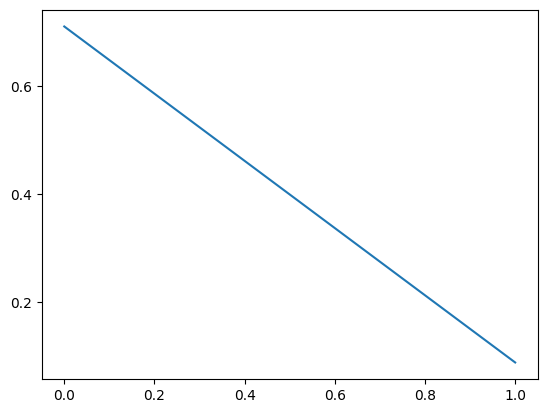

In [18]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=40)

In [19]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> הם מגיעים לכאן בקרוב מהונג קונג
= they are arriving here soon from hong kong
< they are arriving here soon from hong kong <EOS>

> הם כולם מתעצבנים בקלות
= they re all irritable
< they re more popular than we <EOS>

> אני קטן מדי
= i am too short
< i am too tired today <EOS>

> אני כל כך שמחה שהם כאן
= i m so glad they re here
< i m sure with that means <EOS>

> אני לא משוחדת
= i m unprejudiced
< i m not having lunch with you <EOS>

> את גסת רוח
= you re disrespectful
< you re disrespectful <EOS>

> אני שמח שאתה מרגיש כך
= i m glad you feel that way
< i m glad you feel that way <EOS>

> אני הרוסה
= i m devastated
< i m having my family right now <EOS>

> הם צופים
= they re watching
< they are at lunch with my problems <EOS>

> אנחנו כל כך גאים בך !
= we re so proud of you !
< we re so proud of you ? <EOS>



As we can see, the model without attention performs quite bad. The only notable strength is that it correctly matches the sentence structure, such as pronouns ('me,' 'you,' 'we,' etc.), to their appropriate translations most of the time. However, its ability to capture the full meaning and nuances of the sentences is poor.

## 2.a) Training and evaluating a model with attention

Reading lines...
[['go', 'לך !'], ['hi', 'היי'], ['hi', 'אהלן'], ['run !', 'רוץ !'], ['run !', 'רוצי !'], ['run !', 'רוצו !'], ['who ?', 'מי ?'], ['wow !', 'וואו !'], ['wow !', 'ואו !'], ['duck !', 'תתכופפי !']]
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
eng 6206
heb 3067
------------epoch: 1
------------epoch: 2
------------epoch: 3
------------epoch: 4
------------epoch: 5
0m 32s (- 8m 5s) (5 6%) 1.8078
------------epoch: 6
------------epoch: 7
------------epoch: 8
------------epoch: 9
------------epoch: 10
1m 4s (- 7m 33s) (10 12%) 0.9565
------------epoch: 11
------------epoch: 12
------------epoch: 13
------------epoch: 14
------------epoch: 15
1m 36s (- 6m 59s) (15 18%) 0.5654
------------epoch: 16
------------epoch: 17
------------epoch: 18
------------epoch: 19
------------epoch: 20
2m 8s (- 6m 26s) (20 25%) 0.3359
------------epoch: 21
------------epoch: 22
------------epoch: 23
------------epoch: 24
------------epoch: 25
2m 41s 

<Figure size 640x480 with 0 Axes>

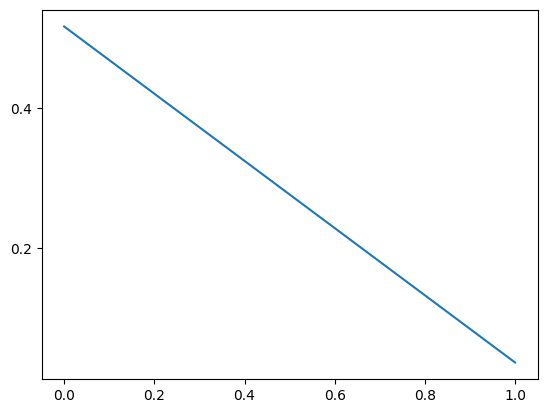

In [20]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=40)


## 2.b) Evaluate the trained model on 20 random sentences.


In [21]:
# Evaluation
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, n=20)

> אנו מתקרבות
= we re getting closer
< we re getting closer <EOS>

> הוא סועד עכשיו את ארוחת הצהריים
= he is having lunch now
< he is having lunch now <EOS>

> היא עסוקה כמו טום
= she s as busy as tom
< she s busy like tom <EOS>

> אני לא סקרן
= i am not curious
< i am not curious <EOS>

> אני פשוט קצת עצבנית
= i m just a little nervous
< i m a little nervous <EOS>

> הוא רע למדי בטניס
= he s pretty bad at tennis
< he s pretty bad at tennis <EOS>

> אני לא נלחם אתך
= i m not fighting with you
< i m not fighting with you <EOS>

> אני עובד על זה
= i m working on that
< i m working on that <EOS>

> אני עדיין כועס עליה
= i m still mad at her
< i m still mad at her <EOS>

> אינני בטוחה מה משמעות הדבר הזה
= i m not sure what this means
< i m not sure what this means what this means

> אתה שקרן טוב יותר משחשבתי
= you re a better liar than i thought
< you re just a nice people <EOS>

> אינני משאיר אותך לבד
= i m not leaving you alone
< you re not leaving you alone <EOS>

> הם כולם שמחים מאוד
=

There are very few sentences that have lost their meaning during the translation process.    
> אני בטוח שתסתדרו  
= i m sure you ll be fine  
< i m sure you meant that <EOS>  

But most of the sentences have translated perfectly.

## 2.c) Showing the attention plot for 5 random sentences.

sentence: אני רגיל להיות ער עד שעה מאוחרת
input = אני רגיל להיות ער עד שעה מאוחרת
output = i m used to staying up late <EOS>


<ipython-input-22-9d22c9ebda82>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + fixed_words +
<ipython-input-22-9d22c9ebda82>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


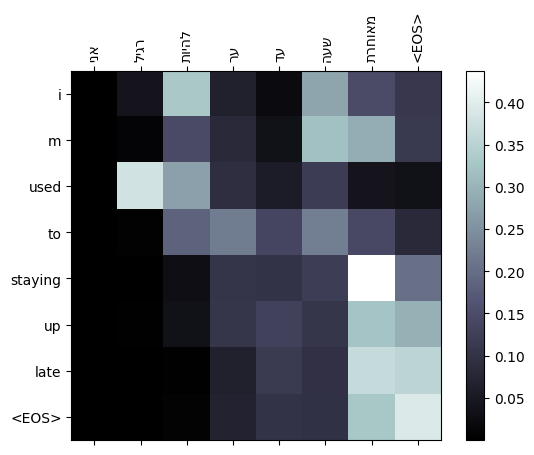

<ipython-input-22-9d22c9ebda82>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + fixed_words +


sentence: את כל כך פרנואיד !
input = את כל כך פרנואיד !
output = you re so paranoid <EOS>


<ipython-input-22-9d22c9ebda82>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


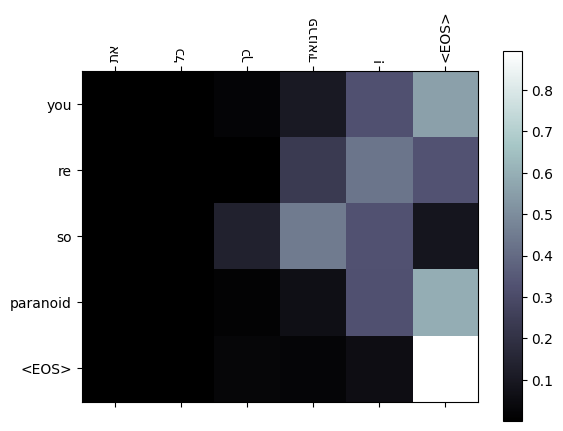

sentence: אני לא הולך לוותר
input = אני לא הולך לוותר
output = i m not going to give up <EOS>


<ipython-input-22-9d22c9ebda82>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + fixed_words +
<ipython-input-22-9d22c9ebda82>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


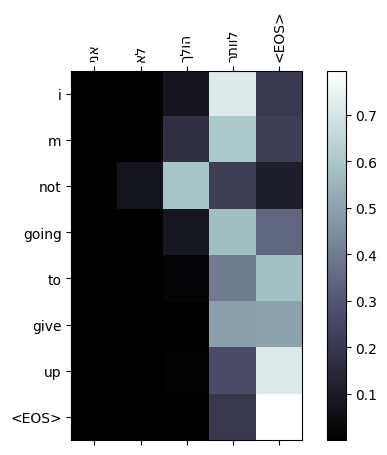

sentence: אנו מנסים לאתר את תום
input = אנו מנסים לאתר את תום
output = we re trying to track tom down <EOS>


<ipython-input-22-9d22c9ebda82>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + fixed_words +
<ipython-input-22-9d22c9ebda82>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


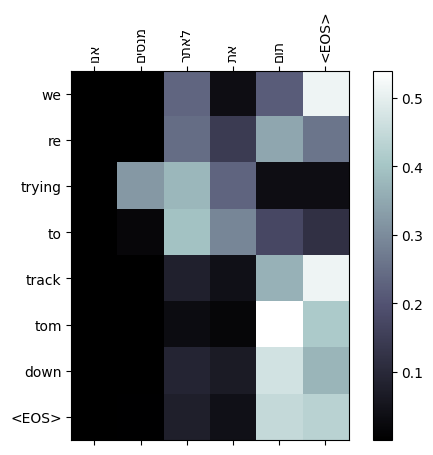

sentence: אני מחכה לאוטובוס
input = אני מחכה לאוטובוס
output = i m waiting for the bus <EOS>


<ipython-input-22-9d22c9ebda82>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + fixed_words +
<ipython-input-22-9d22c9ebda82>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


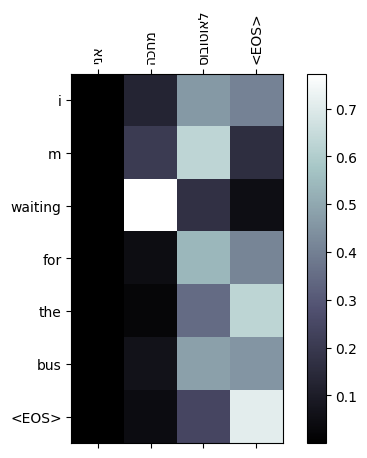

In [22]:
import matplotlib.pyplot as plt
# plt.switch_backend('TkAgg')
import matplotlib.ticker as ticker
def showAttention(input_sentence, output_words, attentions):
    plt.close('all')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    #fixing hebrew words
    words = input_sentence.split(' ')      # ["היא", "מורה"]
    fixed_words = [w[::-1] for w in words]
    ax.set_xticklabels([''] + fixed_words +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close(fig)


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


for i in range(5):
    pair = random.choice(pairs)
    print("sentence:", pair[0])
    evaluateAndShowAttention(pair[0])

## 3)  
Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  

answer:
I think the model performed better compared to the one without attention. However, as we observed, there are still some sentences that lost their meaning or were slightly altered.

Overall, the model performed well, even capturing complex sentences like:  
> הוא כל דבר חוץ מישר  
= he is anything but honest  
< he is anything but honest <EOS>  

To further improve the model, we could use a bidirectional LSTM, allowing the model to leverage context from both directions. Alternatively, we could go even further by using Transformers or other advanced architectures, which have proven highly effective for sequence-to-sequence tasks.
And of course, using more simple methods like Increase Dataset Size, tunining hyperparameters like hidden states can improve the model performens.


## 2.4)
I have changed the GRU (Gated Recurrent Unit) to bidirectional LSTM, the complexity of the model is higher, but it might achieve better results.

In [23]:
class LSTMAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(LSTMAttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.lstm = nn.LSTM(2*hidden_size, hidden_size, batch_first=True, bidirectional=False)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
      batch_size = encoder_outputs.size(0)
      decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

      # LSTMs require (hidden_state, cell_state)
      decoder_hidden = (encoder_hidden, torch.zeros_like(encoder_hidden))  # Initialize cell state

      decoder_outputs = []
      attentions = []

      for i in range(MAX_LENGTH):
          decoder_output, decoder_hidden, attn_weights = self.forward_step(
              decoder_input, decoder_hidden, encoder_outputs
          )
          decoder_outputs.append(decoder_output)
          attentions.append(attn_weights)

          if target_tensor is not None:
              decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
          else:
              _, topi = decoder_output.topk(1)
              decoder_input = topi.squeeze(-1).detach()  # Detach from history

      decoder_outputs = torch.cat(decoder_outputs, dim=1)
      decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
      attentions = torch.cat(attentions, dim=1)

      return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        # LSTM hidden state comes as (h_t, c_t) → only use h_t for attention
        hidden_state = hidden[0]  # Take only h_t

        query = hidden_state.permute(1, 0, 2)  # Ensure correct shape
        context, attn_weights = self.attention(query, encoder_outputs)

        input_lstm = torch.cat((embedded, context), dim=2)

        output, hidden = self.lstm(input_lstm, hidden)  # Correctly pass hidden state
        output = self.out(output)

        return output, hidden, attn_weights

Reading lines...
[['go', 'לך !'], ['hi', 'היי'], ['hi', 'אהלן'], ['run !', 'רוץ !'], ['run !', 'רוצי !'], ['run !', 'רוצו !'], ['who ?', 'מי ?'], ['wow !', 'וואו !'], ['wow !', 'ואו !'], ['duck !', 'תתכופפי !']]
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
eng 6206
heb 3067
------------epoch: 1
------------epoch: 2
------------epoch: 3
------------epoch: 4
------------epoch: 5
0m 33s (- 8m 21s) (5 6%) 1.9440
------------epoch: 6
------------epoch: 7
------------epoch: 8
------------epoch: 9
------------epoch: 10
1m 6s (- 7m 47s) (10 12%) 1.1380
------------epoch: 11
------------epoch: 12
------------epoch: 13
------------epoch: 14
------------epoch: 15
1m 39s (- 7m 13s) (15 18%) 0.7274
------------epoch: 16
------------epoch: 17
------------epoch: 18
------------epoch: 19
------------epoch: 20
2m 13s (- 6m 39s) (20 25%) 0.4562
------------epoch: 21
------------epoch: 22
------------epoch: 23
------------epoch: 24
------------epoch: 25
2m 46

<Figure size 640x480 with 0 Axes>

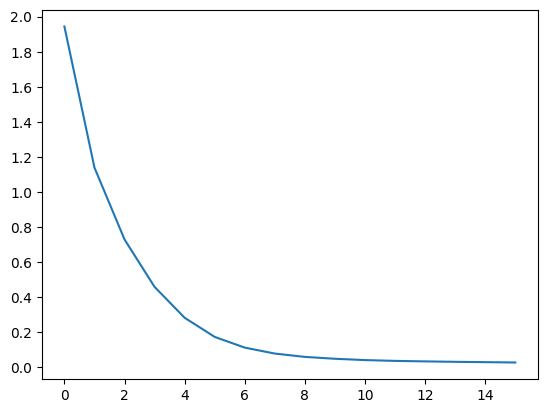

> אני מרוצה מזה
= i m happy with that
< i m happy with that <EOS>

> אתה אדם נבזה
= you re such a mean man
< you re such a mean man that <EOS>

> את אגדית
= you re fabulous
< you re fabulous <EOS>

> אנו לא משוחדים
= we re unbiased
< we re unbiased but not alone <EOS>

> אני גמור
= i m done for
< i m through <EOS>

> אתם פחדנים
= you re yellow
< you re yellow <EOS>

> לא קשה למצוא אותך
= you re not hard to find
< you re not hard to find <EOS>

> אני מרוצה מאד מהביצוע של תום
= i m very pleased with tom s performance
< i m very pleased with tom s performance <EOS>

> אני לגמרי לא בקו הבריאות
= i m not at all well
< i m not at all well <EOS>

> היא חובשת כובע יפה
= she s wearing a nice hat
< she s wearing a nice hat like that hat <EOS>

> אתה שיכור !
= you are drunk !
< you are drunk ! <EOS>

> אני לא מדען
= i m not a scientist
< i m not a scientist <EOS>

> גם אני לא בטוחה בזאת
= i m not sure of it either
< i m not sure of it either <EOS>

> אני שמחה שעזרת לי
= i am glad that you have he

In [24]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder_2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_2 = LSTMAttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder_2, decoder_2, 80, print_every=5, plot_every=5)

encoder_2.eval()
decoder_2.eval()
evaluateRandomly(encoder_2, decoder_2,n=20)

Interestingly, the model with the LSTM performs very well. However, at the end of the sentence, it unnecessarily adds extra words. For example:
> אנו לא משוחדים  
= we re unbiased  
< we re unbiased but not alone <EOS>  

If we limit the number of words in the output sentance, we could have got a pretty good translator.


#END